In [1]:
from dotenv import load_dotenv
import torch
import sys
import os


load_dotenv()  # will load from .env file in the same directory

# Then add this to check the environment:

print(f"CUDA_HOME: {os.environ.get('CUDA_HOME', 'Not set')}")


def check_cuda():
    print(f"PyTorch version: {torch.__version__}")
    print(f"Python version: {sys.version}")

    # Check if CUDA is available
    cuda_available = torch.cuda.is_available()
    print(f"\nCUDA available: {cuda_available}")

    if cuda_available:
        # Get current CUDA device
        current_device = torch.cuda.current_device()
        # Get device properties
        device_props = torch.cuda.get_device_properties(current_device)

        print("\nCUDA Device Details:")
        print(f"  Device: {torch.cuda.get_device_name(current_device)}")
        print(f"  Total memory: {device_props.total_memory / 1024**3:.2f} GB")
        print(f"  CUDA capability: {device_props.major}.{device_props.minor}")
        print(f"  Number of CUDA devices: {torch.cuda.device_count()}")
    else:
        print("\nNo CUDA devices available")


check_cuda()

CUDA_HOME: /run/current-system/sw
PyTorch version: 2.6.0+cu124
Python version: 3.12.9 (main, Feb 12 2025, 14:50:50) [Clang 19.1.6 ]

CUDA available: True

CUDA Device Details:
  Device: NVIDIA GeForce RTX 4060 Ti
  Total memory: 15.60 GB
  CUDA capability: 8.9
  Number of CUDA devices: 1


### get embeddings


In [6]:
# Load model
# model can be downloaded from https://huggingface.co/lingxusb/megaDNA_updated/resolve/main/megaDNA_phage_145M.pt
model_path = "../checkpoints/megaDNA_phage_145M.pt"  # model name
device = "cuda"  # change this to 'cuda' if you use GPU

model = torch.load(model_path, map_location=torch.device(device), weights_only=False)

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
# Load dataset
fasta_file_path = "../dataset/1Jan2025_genomes.fa"
sequences = list(SeqIO.parse(fasta_file_path, "fasta"))

In [5]:
metadata_cleaned = pd.read_csv("../dataset/metadata_cleaned.tsv", sep="\t")

In [10]:
# Create subset where the id is in the metadata_cleaned
seq_subset = [
    seq
    for seq in sequences
    if str(seq.id).strip() in set(metadata_cleaned["Accession"].astype(str).str.strip())
]

In [13]:
# save the subset
with open("../dataset/1Jan2025_genomes_subset.fa", "w") as f:
    for seq in seq_subset:
        f.write(f">{seq.description}\n{str(seq.seq)}\n")

In [3]:
# load the subset
seq_subset = list(SeqIO.parse("../dataset/1Jan2025_genomes_subset.fa", "fasta"))

In [4]:
print(len(seq_subset))

8069


In [7]:
def get_embeddings(sequence, model, device, max_seq_length=131072):
    """Get embeddings for a single sequence
    Args:
        sequence: Input DNA sequence
        model: MEGADNA model
        device: torch device (CPU/GPU)
        max_seq_length: Maximum sequence length (default: 131072 from model dimensions 128*64*16)
    Returns:
        combined_emb: 964-dimensional embedding vector (on GPU)
    """
    # Check sequence length
    if len(sequence) > max_seq_length:
        print(f"Warning: Sequence length {len(sequence)} exceeds max length {max_seq_length}")
        sequence = sequence[:max_seq_length]

    # Encode sequence
    nt_vocab = ["**", "A", "T", "C", "G", "#"]
    encoded = [0]  # Start token
    for nucleotide in str(sequence):
        if nucleotide in nt_vocab:
            encoded.append(nt_vocab.index(nucleotide))
        else:
            encoded.append(1)
    encoded.append(5)  # End token

    input_seq = torch.tensor(encoded).unsqueeze(0).to(device)

    with torch.no_grad():
        embeddings = model(input_seq, return_value="embedding")
        local_emb = torch.mean(embeddings[0].squeeze(), dim=0)  # (512,)
        middle_emb = torch.mean(torch.mean(embeddings[1].squeeze(), dim=0), dim=0)  # (256,)
        global_emb = torch.mean(torch.mean(embeddings[2].squeeze(), dim=0), dim=0)  # (196,)
        combined_emb = torch.cat([local_emb, middle_emb, global_emb])  # (964,)

    return combined_emb


def process_sequences(sequences, model, device, batch_size=50, max_seq_length=131072):
    """Process multiple sequences in batches
    Args:
        sequences: List of sequences to process
        model: MEGADNA model
        device: torch device (CPU/GPU)
        batch_size: Number of sequences to process at once
        max_seq_length: Maximum sequence length (default: 131072 from model dimensions 128*64*16)
    Returns:
        all_embeddings: Tensor of shape (n_sequences, 964) containing embeddings
    """
    all_embeddings = torch.zeros((len(sequences), 964), device=device)

    # Create progress bar for all sequences
    with tqdm(total=len(sequences), desc="Processing sequences") as pbar:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i : i + batch_size]

            for j, record in enumerate(batch):
                try:
                    all_embeddings[i + j] = get_embeddings(
                        record.seq, model, device, max_seq_length
                    )
                except Exception as e:
                    print(f"Error processing sequence {record.id}: {str(e)}")

                pbar.update(1)  # Update progress bar for each sequence

    return all_embeddings

In [ ]:
# Process all sequences
embeddings = process_sequences(
    sequences=seq_subset, model=model, device=device, batch_size=50, max_seq_length=131072
)

print("\nFinal embeddings shape:", embeddings.shape)  # Should be (number of sequences, 964)

# Save embeddings and sequence information
embeddings_np = embeddings.cpu().numpy()
headers = [record.description for record in seq_subset]
np.save("../results/embeddings.npy", embeddings_np)
np.save("../results/headers.npy", np.array(headers))

### clustering based on embeddings


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
# Load data
embeddings = np.load("../results/embeddings.npy")
headers = np.load("../results/headers.npy")
metadata_cleaned = pd.read_csv("../dataset/metadata_cleaned.tsv", sep="\t")

# Scale features
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Create dataframe with metadata
accessions = [header.split()[0] for header in headers]
df = pd.DataFrame({"Accession": accessions})
df = df.merge(metadata_cleaned[["Accession", "Genus", "Family", "Host"]], on="Accession")

In [ ]:
def analyze_clusters(clusters, df, method_name, n_components, explained_var, output_file):
    def calculate_purity(cluster_labels, taxonomy_labels):
        total = len(cluster_labels)
        purity = 0
        for cluster in np.unique(cluster_labels):
            cluster_mask = cluster_labels == cluster
            if sum(cluster_mask) > 0:
                most_common = pd.Series(taxonomy_labels[cluster_mask]).mode()[0]
                purity += sum(taxonomy_labels[cluster_mask] == most_common)
        return purity / total

    with open(output_file, "a") as f:
        f.write(f"\n{'=' * 50}\n")
        f.write(f"Clustering Method: {method_name}\n")
        f.write(f"PCA dimensions: {n_components} (explained variance: {explained_var:.3f})\n")
        f.write(f"{'=' * 50}\n\n")

        # Analyze each cluster
        for cluster in sorted(np.unique(clusters)):
            cluster_mask = clusters == cluster
            cluster_size = sum(cluster_mask)

            f.write(f"Cluster {cluster} (Size: {cluster_size})\n\n")

            # Top Genera
            f.write("Top Genera:\n")
            genera_counts = df[cluster_mask]["Genus"].value_counts().head()
            f.write(genera_counts.to_string())
            f.write("\n\n")

            # Top Families
            f.write("Top Families:\n")
            family_counts = df[cluster_mask]["Family"].value_counts().head()
            f.write(family_counts.to_string())
            f.write("\n\n")

            # Top Hosts
            f.write("Top Hosts:\n")
            host_counts = df[cluster_mask]["Host"].value_counts().head()
            f.write(host_counts.to_string())
            f.write("\n\n")
            f.write("-" * 50 + "\n")

        # Calculate purity scores
        genus_purity = calculate_purity(clusters, df["Genus"])
        family_purity = calculate_purity(clusters, df["Family"])
        host_purity = calculate_purity(clusters, df["Host"])

        f.write("\nCluster Purity Scores:\n")
        f.write(f"Genus Purity: {genus_purity:.3f}\n")
        f.write(f"Family Purity: {family_purity:.3f}\n")
        f.write(f"Host Purity: {host_purity:.3f}\n\n")

In [ ]:
# PCA dimensions to try
pca_dimensions = [2, 10, 20, 50, 100, 200, 500, 964]  # 964 is original dimension

# Numbers of clusters to try - MODIFY THIS LIST TO CHANGE CLUSTER NUMBERS
n_clusters_list = [100, 200, 300, 500]  # Example: wider range of clusters

# DBSCAN parameters
dbscan_params = {"eps": 5, "min_samples": 5}

output_file = "../results/clustering_analysis.txt"

# Clear file
with open(output_file, "w") as f:
    f.write("Clustering Analysis Results with Different PCA Dimensions and Cluster Numbers\n\n")

# Try each PCA dimension
for n_components in pca_dimensions:
    if n_components < 964:
        pca = PCA(n_components=n_components)
        embeddings_reduced = pca.fit_transform(embeddings_scaled)
        explained_var = sum(pca.explained_variance_ratio_)
    else:
        embeddings_reduced = embeddings_scaled
        explained_var = 1.0

    # Try different numbers of clusters
    for n_clusters in n_clusters_list:
        # K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings_reduced)
        analyze_clusters(
            clusters,
            df,
            f"K-means (n_clusters={n_clusters})",
            n_components,
            explained_var,
            output_file,
        )

        # Hierarchical
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = hierarchical.fit_predict(embeddings_reduced)
        analyze_clusters(
            clusters,
            df,
            f"Hierarchical (n_clusters={n_clusters})",
            n_components,
            explained_var,
            output_file,
        )

    # DBSCAN
    dbscan = DBSCAN(**dbscan_params)  # type: ignore
    clusters = dbscan.fit_predict(embeddings_reduced)
    analyze_clusters(
        clusters,
        df,
        f"DBSCAN (eps={dbscan_params['eps']}, min_samples={dbscan_params['min_samples']})",
        n_components,
        explained_var,
        output_file,
    )

### protein


Found 1375 common accessions between datasets
Using subset of 500 sequences


Calculating protein distances: 100%|██████████| 124750/124750 [39:26<00:00, 52.72it/s] 


Normalizing distances...
Finding top pairs...

Top pairs with different DNA but similar proteins:

Pair: NC_047755 - KP791807
DNA distance: 4.029
Protein distance: 0.056
Difference score: 0.266

Pair: NC_047755 - NC_029102
DNA distance: 3.996
Protein distance: 0.055
Difference score: 0.264

Pair: NC_015249 - NC_047984
DNA distance: 4.289
Protein distance: 0.111
Difference score: 0.232

Pair: NC_010807 - NC_071009
DNA distance: 4.191
Protein distance: 0.106
Difference score: 0.230

Pair: NC_071009 - NC_031066
DNA distance: 4.119
Protein distance: 0.106
Difference score: 0.224

Pair: NC_071009 - NC_047843
DNA distance: 4.285
Protein distance: 0.137
Difference score: 0.206

Pair: NC_021337 - NC_042006
DNA distance: 4.303
Protein distance: 0.143
Difference score: 0.201

Pair: NC_022744 - NC_047984
DNA distance: 4.164
Protein distance: 0.132
Difference score: 0.201

Pair: NC_004777 - JQ965701
DNA distance: 2.565
Protein distance: 0.005
Difference score: 0.200

Pair: NC_047844 - KP791807
DNA

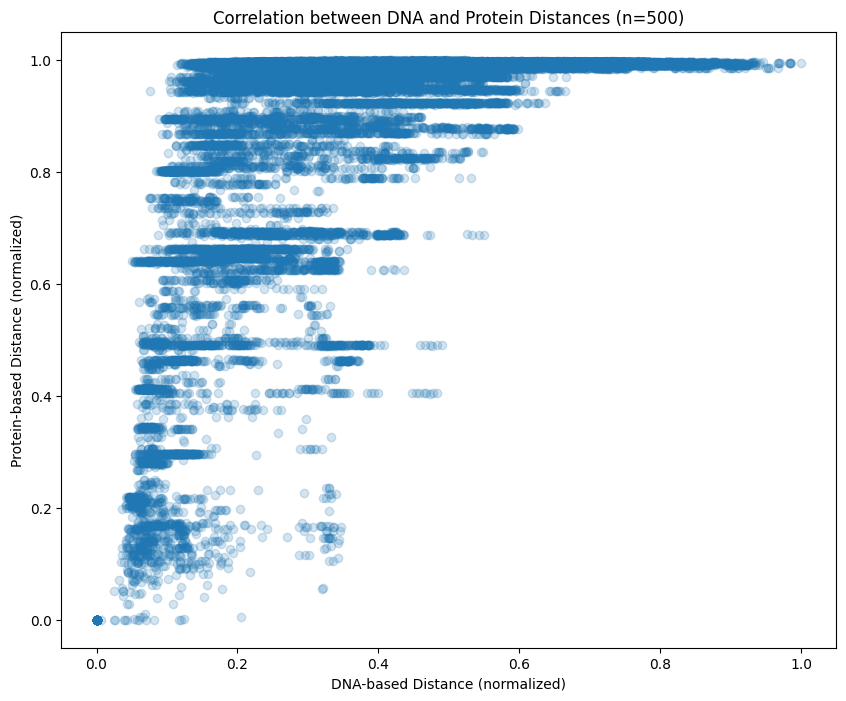

In [26]:
import numpy as np
from Bio import Phylo
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load data
embeddings = np.load("../results/embeddings.npy")
headers = np.load("../results/headers.npy")
accessions = [header.split()[0] for header in headers]
protein_tree = Phylo.read("../dataset/set.bionj.newick", "newick")  # type: ignore
tree_terminals = [terminal.name for terminal in protein_tree.get_terminals()]

# Find common accessions
common_accessions = []
accession_indices = []
tree_names = []

for i, acc in enumerate(accessions):
    if acc in tree_terminals:
        common_accessions.append(acc)
        accession_indices.append(i)
        tree_names.append(acc)

n = len(common_accessions)
print(f"Found {n} common accessions between datasets")

# Use smaller subset for testing
use_subset = True  # Set to False to use all data
if use_subset:
    subset_size = 500
    if n > subset_size:
        indices = np.random.choice(n, subset_size, replace=False)
        common_accessions = [common_accessions[i] for i in indices]
        accession_indices = [accession_indices[i] for i in indices]
        tree_names = [tree_names[i] for i in indices]
        n = subset_size
        print(f"Using subset of {n} sequences")

# Calculate distances
embeddings_subset = embeddings[accession_indices]
dna_distances = pdist(embeddings_subset, metric="euclidean")
dna_distances = squareform(dna_distances)

# Get protein-based distances from tree with progress bar
protein_distances = np.zeros((n, n))
total_pairs = (n * (n - 1)) // 2

with tqdm(total=total_pairs, desc="Calculating protein distances") as pbar:
    for i in range(n):
        for j in range(i + 1, n):
            dist = protein_tree.distance(
                protein_tree.find_any(name=tree_names[i]), protein_tree.find_any(name=tree_names[j])
            )
            protein_distances[i, j] = dist
            protein_distances[j, i] = dist
            pbar.update(1)

# Normalize distances
print("Normalizing distances...")
dna_dist_normalized = (dna_distances - dna_distances.min()) / (
    dna_distances.max() - dna_distances.min()
)
protein_dist_normalized = (protein_distances - protein_distances.min()) / (
    protein_distances.max() - protein_distances.min()
)

difference = dna_dist_normalized - protein_dist_normalized

# Get top pairs
n_pairs = 10
print("Finding top pairs...")
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((i, j, difference[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop pairs with different DNA but similar proteins:")
for i, j, diff in pairs[:n_pairs]:
    print(f"\nPair: {common_accessions[i]} - {common_accessions[j]}")
    print(f"DNA distance: {dna_distances[i, j]:.3f}")
    print(f"Protein distance: {protein_distances[i, j]:.3f}")
    print(f"Difference score: {diff:.3f}")

# Visualize correlation
plt.figure(figsize=(10, 8))
plt.scatter(dna_dist_normalized.flatten(), protein_dist_normalized.flatten(), alpha=0.1)
plt.xlabel("DNA-based Distance (normalized)")
plt.ylabel("Protein-based Distance (normalized)")
plt.title(f"Correlation between DNA and Protein Distances (n={n})")
plt.show()